Counting train and test directory's length

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator

BASE_DIR = '/media/abel/TERA/School/5to/IA/IA Project/fer2013'
TRAIN_DIR = os.path.join(BASE_DIR,'train')
TEST_DIR = os.path.join(BASE_DIR,'test')

total_train = 0
total_test = 0

for e in os.listdir(TRAIN_DIR):
    total_train +=  len(os.listdir(os.path.join(TRAIN_DIR,e)))

for e in os.listdir(TEST_DIR):
    total_test +=  len(os.listdir(os.path.join(TEST_DIR,e)))

print('train length:',total_train)
print('test length:',total_test)


train length: 28709
test length: 7178


Crear generador de imágenes. Nos permite configurar rápidamente
generadores de python que pueden convertir automáticamente archivos de imagen en el disco en
batches de tensores preprocesados.
flow_from_directory recibe:
- Directorio con imágenes.
- Cantidad de imágenes por batch.
- Rescalado de las imágenes.
- Determina el tipo de array de etiquetas a devolver. En este caso categorical porque usaremos sparse_categorical_crossentropy como nuestra función de pérdida.

In [2]:
# train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.20)

train_datagen = ImageDataGenerator(
validation_split=0.20,
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
) 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
TRAIN_DIR,
target_size=(48, 48),
batch_size=32,
subset='training',
class_mode='categorical')

valid_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48, 48),
    batch_size=32,
    class_mode="categorical",
    subset='validation',
)

test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(150, 150),
    batch_size=37,
    class_mode="categorical"
)

train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
)


# train_generator = train_datagen.flow_from_directory(
# TRAIN_DIR,
# target_size=(150, 150),
# batch_size=22,
# class_mode='categorical',
# subset='training')

# valid_generator = train_datagen.flow_from_directory(
# TRAIN_DIR,
# target_size=(150, 150),
# batch_size=20,
# class_mode="categorical",
# subset='validation')


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.



['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral'

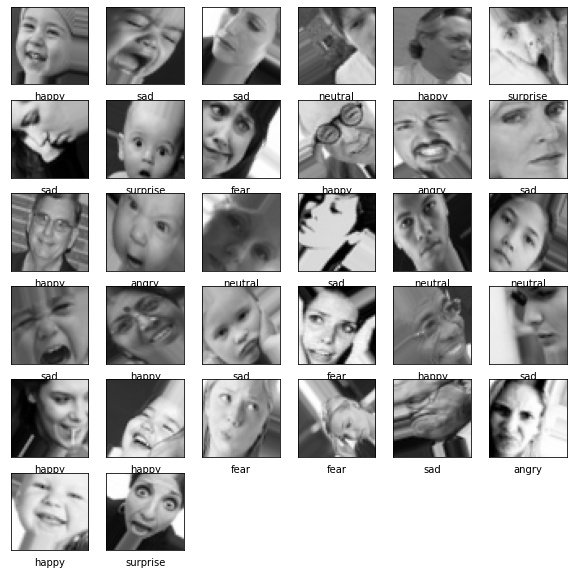

In [3]:
plt.figure(figsize=(10,10))
images_batch, labels_batch = train_generator.next()
print()
for i,p in enumerate(images_batch):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(p), cmap=plt.cm.binary)
    plt.xlabel(list(train_generator.class_indices.keys())[np.argmax(labels_batch[i])])
    print(list(train_generator.class_indices.keys()))


#### Building the model
En la siguiente sección se define la arquitectura de la red neuronal convolusional.
Para ello se colocan una serie de capas convolucionales 2d seguidas de capas maxpooling. El output de la última capa de convolución se aplana para obtner una entrada de una sola dimensión. Esta se pasa a una red neuronal encargada de determinar la emoción más probable dada una foto inicial.

In [4]:
from keras import layers
from keras import models
# from keras import regularizers

def build_cnn_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (5, 5),padding='same' ,activation='relu',input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(64, (5, 5),padding='same' , activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.BatchNormalization())


    model.add(layers.Conv2D(128, (3, 3),padding='same' , activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.BatchNormalization())


    model.add(layers.Conv2D(128, (3, 3),padding='same' , activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.BatchNormalization())


    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.Dense(7, activation='softmax'))

    return model

cnn_model = build_cnn_model()
print(cnn_model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

2022-06-29 14:52:00.548199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 14:52:00.579615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 14:52:00.579776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 14:52:00.580288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

#### Compilation process
Definimos la función de pérdida, el optimizador y las métricas como el learning rate; empleando la función compile.

In [35]:
from keras import optimizers
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=5e-4),#usar sgd
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Train the model

In [36]:
history = cnn_model.fit(
        train_generator,
        batch_size = 32,
        epochs=30,
        validation_data=valid_generator,
        validation_steps=50)

cnn_model.save('emotions_rec_1.0.h5')

Epoch 1/30
  51/1044 [>.............................] - ETA: 3:58 - loss: 1.8657 - accuracy: 0.2424

KeyboardInterrupt: 

#### Plot tranning process

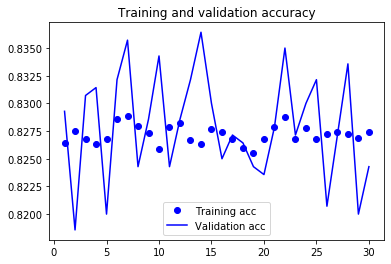

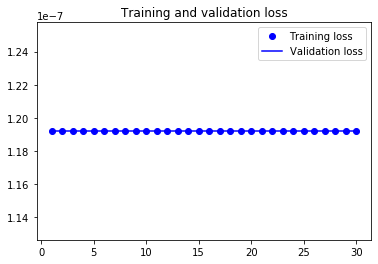

In [19]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Test the model

In [11]:
score = cnn_model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

288/288 [==============================] - 26s 91ms/step - loss: 1.2950 - accuracy: 0.5076
Test loss: 1.2950149774551392
Test accuracy: 0.5075770616531372
